In [1]:
import pandas as pd
import numpy as np
import re
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from nltk import  word_tokenize
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix,recall_score,precision_score

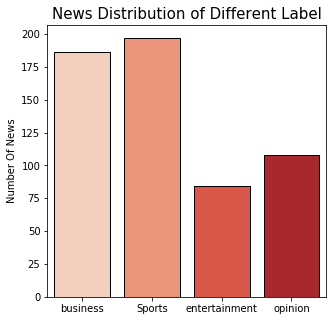

In [2]:
Raw_Data=pd.read_csv('scrap_news.csv')
aa=Raw_Data.groupby('label').count().reset_index()
plt.figure(figsize = (5,5))
sns.barplot(x =['business','Sports','entertainment','opinion'],y = "news",data = aa,
                linewidth = 1 ,edgecolor = "k"*5,palette = "Reds")
plt.title("News Distribution of Different Label",fontsize=15)
plt.ylabel('Number Of News',fontsize=10)
plt.show()

In [3]:
stop = stopwords.words('nepali')
Raw_Data['stopwords'] = Raw_Data['news'].apply(lambda x: len([x for x in x.split() if x in stop]))
Raw_Data[['news','stopwords']].head()

,news,stopwords
0,काठमाडौँ — ट्वान्टी–२० मा स्कटल्यान्डबाट ओपनिङ...,29
1,म्यानचेस्टर — म्यानचेस्टर सिटी व्यवस्थापक पेप ...,73
2,धनगढी — देशकै सर्वाधिक धनराशिको चौथो अन्तर्राष...,19
3,सुनसरी — आयोजक धरान फुटबल क्लबले २२ औं आमन्त्र...,64
4,बिर्तामोड — रुस्लान थ्रीस्टार क्लब झिलझिलेमा ज...,48


In [4]:
stop_words = stopwords.words("nepali")
def string_manipulation(df,column)  : 
    df[column] = df[column].apply(lambda x: re.sub('[।(),०-९<<?!,—,–,/,’,‘,:]', '', x))
    df[column] = df[column].apply(lambda x: " ".join([i for i in x.split()if i not in (stop_words)]))

    return df
Data = string_manipulation(Raw_Data,"news")
Data = Data.sample(frac=1,random_state=20).reset_index(drop=True)
Data.head(1)


,Unnamed: 0,news,label,stopwords
0,91,काठमाडौँ नेपाली राष्ट्रिय फुटबल टिमले विश्वकप ...,खेलकुद,75


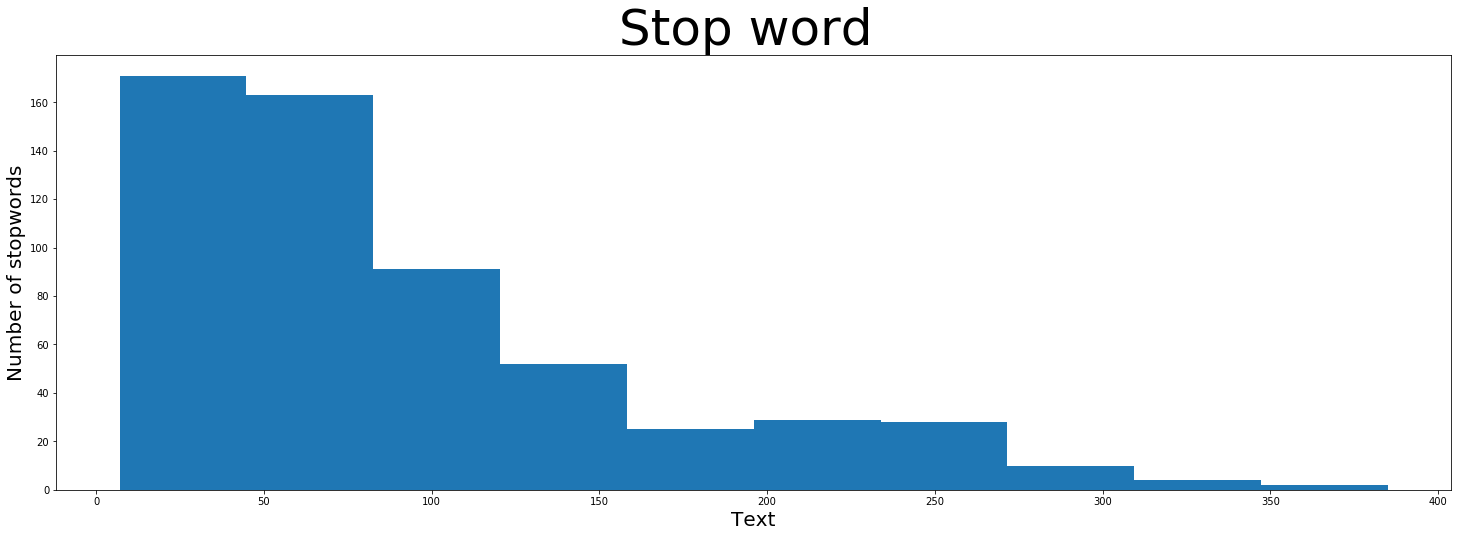

In [5]:
plt.figure(figsize=(25,8))
plt.title("Stop word ",fontsize=50)
plt.xlabel("Text",fontsize=20)
plt.ylabel("Number of stopwords",fontsize=20)
plt.hist(Data.stopwords)
plt.show()

In [6]:
pop_wrds = (Data["news"].apply(lambda x : 
                                         pd.value_counts(x.split(" ")))
            .sum(axis = 0).reset_index().sort_values(by = [0],ascending = False))
pop_wrds.columns = ["word","count"]
pop_wrds.head()

,word,count
0,नेपाली,700.0
221,रूपमा,642.0
1771,बताए,637.0
668,सय,617.0
191,हजार,578.0


/home/sudu/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 2344 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/sudu/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 2375 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/sudu/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 2346 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/sudu/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 2366 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/sudu/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 2354 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/sudu/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarn

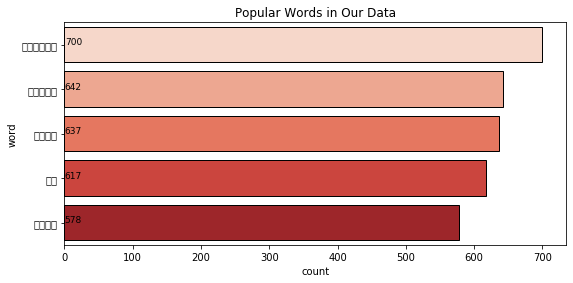

In [7]:
plt.figure(figsize = (9,9))
plt.subplot(211)
ax = sns.barplot(x = "count",y = "word",data = pop_wrds[:5],
                linewidth = 1 ,edgecolor = "k"*5,palette = "Reds")
plt.title("Popular Words in Our Data")

for i,j in enumerate(pop_wrds["count"][:5].astype(int)) :
    ax.text(.8,i,j,fontsize = 9)

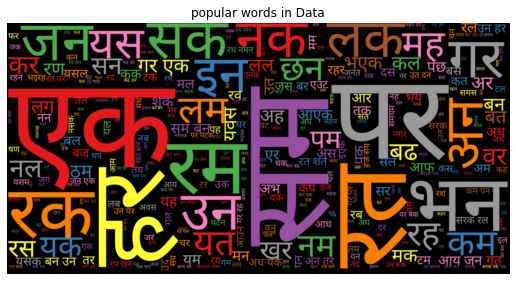

In [8]:
def build_word_cloud(words,back_color,palette,title) :
    word_cloud = WordCloud(font_path='NotoSans-Regular.ttf',scale = 7,max_words = 1000,
                           max_font_size = 100,background_color = back_color,
                           random_state = 0,colormap = palette
                          ).generate(" ".join(words))
    plt.figure(figsize=(9,9))
    plt.imshow(word_cloud,interpolation = "bilinear")
    plt.axis("off")
    plt.title(title)
    plt.show()
build_word_cloud(Data["news"],"black","Set1","popular words in Data")

In [9]:
total_word = Data.news.tolist()
vectorizer = TfidfVectorizer(ngram_range=(1, 2))
vectorizer.fit(total_word)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 2), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [10]:
news_train, news_test,label_train,label_test =train_test_split(Data['news'], Data['label'],test_size=0.2, random_state=1)

In [11]:
train_vectorized = vectorizer.transform(news_train)
test_vectorized = vectorizer.transform(news_test)

In [12]:
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
svm = OneVsRestClassifier(SVC(C=1, kernel='sigmoid'))
svm = svm.fit(train_vectorized, label_train)

/home/sudu/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/sudu/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/sudu/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/sudu/anaconda3/lib/python3.7/site-packages/sklearn/svm/

In [13]:
svm_acc = svm.score(test_vectorized, label_test)
print('SVM accuracy', svm_acc)

SVM accuracy 0.8


In [14]:
review = ["आयोजनामा ट्वान्टी–२० क्रिकेट प्रतिगोगिता बुधबारदेखि सुरु भएको छ। महाराजगञ्जस्थित पाकिस्तान दूतावासको क्रिकेट ग्राउन्डमा भएको प्रतियोगिताको काठमाडौं महानगरपालिकाका मेयर विद्यासुन्दर शाक्यले उद्घाटन गरेका थिए।",
         "अर्ब ६३ करोड ६३ लाख ३९ हजार ५६० मूल्य बराबरको शेयर किनबेच भएको छ। नेपालस्टक एक्चेन्ज(नेप्से) परिसूचक साताभारमा १७ अंकले बढेको छ।"]

def print_prediction(review, model):
    print("*****EVALUATE REVIEW*******")
    review_vectorized = vectorizer.transform(review)
    y_pred = model.predict(review_vectorized)
    for each_review, each_y_pred in zip(review, y_pred):
        print("{0}: Category is -> {1}".format(each_review, each_y_pred))

In [15]:
print_prediction(review, svm)

*****EVALUATE REVIEW*******
आयोजनामा ट्वान्टी–२० क्रिकेट प्रतिगोगिता बुधबारदेखि सुरु भएको छ। महाराजगञ्जस्थित पाकिस्तान दूतावासको क्रिकेट ग्राउन्डमा भएको प्रतियोगिताको काठमाडौं महानगरपालिकाका मेयर विद्यासुन्दर शाक्यले उद्घाटन गरेका थिए।: Category is -> खेलकुद
अर्ब ६३ करोड ६३ लाख ३९ हजार ५६० मूल्य बराबरको शेयर किनबेच भएको छ। नेपालस्टक एक्चेन्ज(नेप्से) परिसूचक साताभारमा १७ अंकले बढेको छ।: Category is -> अर्थ / वाणिज्य


In [16]:
predict=svm.predict(test_vectorized)
SVMTrainAccuracy=svm.score(train_vectorized,label_train)
SVMTestAccuracy=svm.score(test_vectorized,label_test)
SVMAccuracy=accuracy_score(predict,label_test)
SVMRecall=recall_score(predict,label_test,average = "macro")
SVMPrecision=precision_score(predict,label_test,average = "macro")
SVMF1_score=f1_score(predict,label_test,average = "macro")
accuracy=[[SVMAccuracy,SVMRecall,SVMPrecision,SVMF1_score,SVMTrainAccuracy,SVMTestAccuracy]]
df = pd.DataFrame(accuracy,columns = [ 'accuracy','recall','precision','F1','TrainAccuracy','TestAccuracy'])

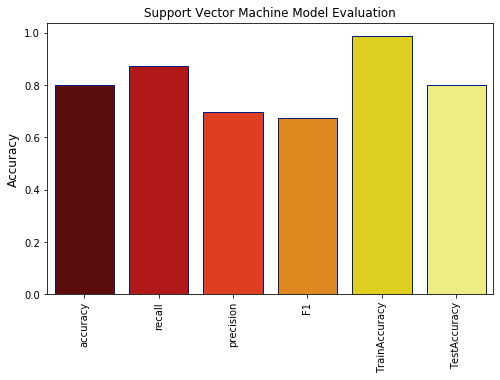

In [17]:
plt.figure(figsize = (8,5))
sns.barplot(data=df,palette='hot',edgecolor=sns.color_palette('dark',1))
plt.xticks(rotation=90)
plt.title('Support Vector Machine Model Evaluation')
plt.ylabel('Accuracy',fontsize=12)
plt.show()

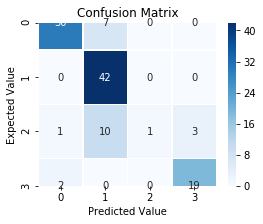

In [18]:
fig, ax = plt.subplots(figsize=(4,3))
confusion_mat=sns.heatmap(confusion_matrix(label_test,predict), annot=True, linewidths=.5, ax=ax, cmap="Blues", fmt="d").set(xlabel='Predicted Value', ylabel='Expected Value')
plt.title('Confusion Matrix')
plt.show()
